# Problema de Negócio:

* A Vale S.A. (VALE3) é uma das principais empresas de mineração listadas na B3, com forte impacto no portfólio de investidores institucionais e pessoa física no Brasil. Para um gestor de investimentos ou analista de mercado, antecipar a trajetória do preço de fechamento (Close) e entender os padrões de volume de negociação é crucial para:

    1. Tomar decisões de compra/venda com melhor relação risco-retorno;

    2. Ajustar a alocação de ativos de curto a médio prazo;

    3. Desenvolver estratégias de trading baseadas em sinais estatísticos e de machine learning;

    4. Gerenciar o risco por meio de previsões confiáveis e métricas de incerteza.

* Objetivo Geral:
Desenvolver um modelo preditivo de séries temporais para o preço de fechamento diário de VALE3, de modo a gerar forecasts de 30 a 90 dias futuros e embasar decisões de investimento.

* Importando as bibliotecas necessárias: 

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as scs
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# 1. Análise exploratória e tratamento de dados:

In [ ]:
# Primeiramente, vamos importar a base de dados que contém os preços das ações da Vale S.A:
# Vamos baixar as ações da Vale S.A:
vale = yf.download('VALE3.SA', start='2018-01-01', end='2024-12-31', multi_level_index=False)
vale = vale[['Close', 'Open']]
vale = vale.reset_index()
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)
vale

* Vamos fazer uma descrição dos dados:

In [ ]:
vale.describe()

In [ ]:
# Vamos visulizar os dados com ajuda de um boxplot:
plt.figure(figsize=(12,6))
sns.boxplot(data=vale[['Open','Close']])
plt.title('Boxplot dos preços de fechamento e abertura da VALE3.')

* Podemos observar no boxplot dos preços de fechamento e abertura das ações da VALE3:

1. Ambos os valores, fechamento e abertura, apresentam variação entre R$ 20 e R$ 80 reais.

2. As distribuições de Open e Close são parecidas, indicando que os preços de abertura e fechamento da VALE3 costumam ser próximos no mesmo dia.

* Detalhamento por variável:

    🟦 Open (Abertura):
    * Mediana: ~ R$55 reais 
    * 1° Quartil: ~ R$30 reais
    * 2° Quartil: ~ R$60 reais 
    * A caixa(entre Q1 e Q3) apresenta maior concentração de preços.
    * A dispersão é grande, mas sem outliers visíveis.

    🟧 Close (Fechamento):
    * Mediana: também em torno de R$ 55 reais, muito próxima da de Open.

    * Faixa interquartil também parecida.

    * Os extremos mínimo e máximo (sem outliers) indicam que os fechamentos seguem uma dinâmica parecida com as aberturas.  

* Agora vamos agrupar as ações por meses e anos:

In [ ]:
# Média mensal para suavização ou input em modelos preditivos:
df_acoes_anos = vale[['Close', 'Open']].resample('Y').mean()
df_acoes_anos['Variação'] = df_acoes_anos['Close'].pct_change() * 100
df_acoes_anos['Variação'] = df_acoes_anos['Variação'].fillna(0)
df_acoes_anos

In [ ]:
# Retornos mensais reais (para estratégia ou avaliação de desempenho):
df_mensal_CO = vale[['Close', 'Open']].resample('M').agg({
    'Close': 'last',
    'Open': 'first'
})
df_mensal_CO['Retorno_Mensal'] = df_mensal_CO['Close'].pct_change() * 100

# Média mensal para suavização ou input em modelos preditivos:
df_acoes_meses = vale[['Close', 'Open']].resample('M').mean()
df_acoes_meses['Retorno_Mensal'] = df_acoes_meses['Close'].pct_change() * 100
df_acoes_meses['Retorno_Mensal'] = df_acoes_meses['Retorno_Mensal'].fillna(0)

In [ ]:
df_acoes_meses

* O que podemos extrair de insights das ações da Vale S.A entre 2018 à 2024?

1. Fase de crescimento(2018 - 2021):
    * A demanda por minério de ferro apresentou uma tendência geral de crescimento entre 2018 e 2021, apesar de algumas flutuações. Inicialmente, houve uma queda entre 2018 e 2020, impulsionada em parte pela pandemia de COVID-19, mas a demanda retomou a trajetória de crescimento em 2021. A China, como maior consumidora global, teve um papel crucial neste crescimento, puxando a demanda e os preços do minério de ferro.
    Isso explica o porque, mesmo com uma pandemia ocorrendo no Brasil, entre 2019 e 2021 as ações da Vale S.A tiveram uma valorização de até 83%.

2. Fase de correção(2022 - 2024):
    * A partir de 2022, a ação entrou em uma tendência de queda, com variações negativas consecutivas: -2.98% (2022), -0.98% (2023) e -7.24% (2024). Isso sugere uma correção após o pico de 2021, com a queda mais acentuada em 2024.
    Outros fatore importantes são: a queda no preço das commodities de ferro e a volatilidade financeira nos mercados globais.

3. Volatilidade:
    * A ação demonstra alta volatilidade ao longo do período, com variações extremas em 2021 (crescimento de 83.85%) e 2024 (queda de 7.24%). Isso indica que a VALE3 é sensível a mudanças no mercado ou eventos específicos.


4. Relação entre Close e Open:
    * Em todos os anos, os preços de abertura e fechamento são muito próximos dentro de cada ano. Isso sugere que as grandes variações percentuais ocorreram ao longo dos meses, e não entre o último dia de um ano e o primeiro dia do ano seguinte.


# 2. Visualização de Tendências e Sazonalidades: 

* Vamos plotar um gráfico de linha com médias móveis, para vermos como o preço de fechamento das ações se comportou:

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(vale['Close'], label='Preço de Fechamento',alpha=0.5)
plt.plot(vale['Close'].rolling(window=7).mean(), label='Média Móvel de 7 dias', color='purple', alpha=0.7)
plt.plot(vale['Close'].rolling(window=15).mean(), label='Média Móvel de 15 dias', color='yellow', alpha=0.7)
plt.plot(vale['Close'].rolling(window=30).mean(), label='Média Móvel de 30 dias', color='orange', alpha=0.7)
plt.plot(vale['Close'].rolling(window=60).mean(), label='Média Móvel de 60 dias', color='green', alpha=0.7)
plt.plot(vale['Close'].rolling(window=90).mean(), label='Média Móvel de 90 dias', color='red', alpha=0.7)
plt.title('Médias Móveis dos Preços de Fechamento da VALE3')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* Vamos observar as tendências sazonais no nosso DataFrame:

In [ ]:
result = seasonal_decompose(vale['Close'], model='multiplicative', period=90)
result.plot()

# 3. Vamos aplicar o modelo Prophet:

18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:49 - cmdstanpy - INFO - Chain [1] done processing


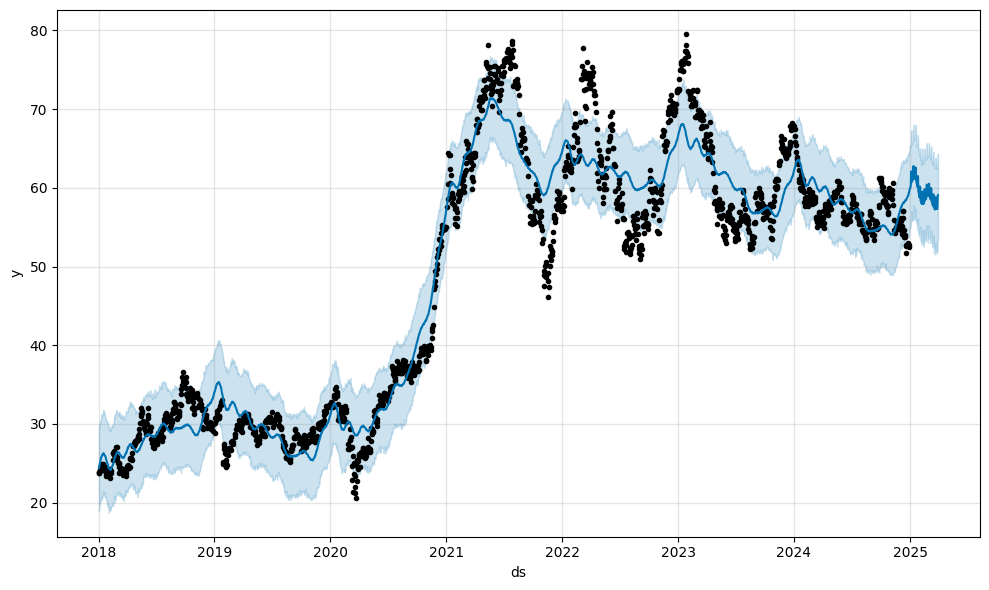

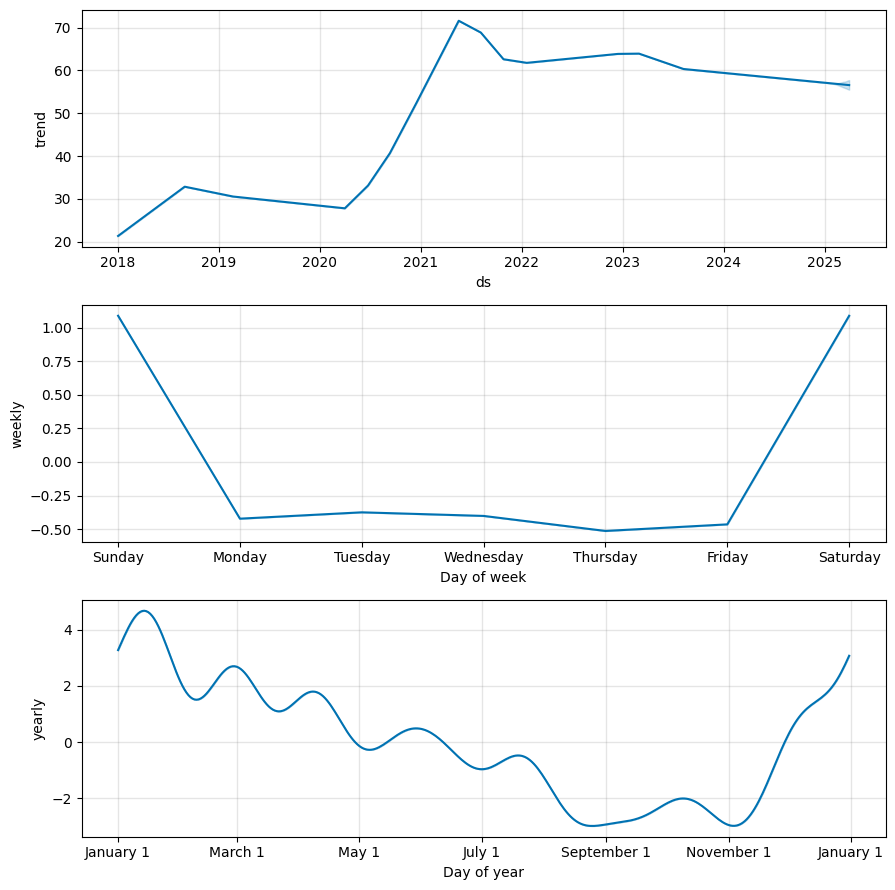

In [14]:
# Criando um DataFrame com os preços de fechamento:
vale_df = vale[['Close']].reset_index()
vale_df = vale_df.rename(columns={'Date': 'ds', 'Close': 'y'})
vale_df['ds'] = pd.to_datetime(vale_df['ds'])

# Criando o modelo Prophet:
m = Prophet()
m.fit(vale_df)

# Criando um DataFrame para prever os próximos 90 dias:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

# Visualizando as previsões:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
plt.show()

* Validação do modelo:

MAPE:  6.577799465618472
MAE 3.125221864859205
R2:  0.9402472290601865


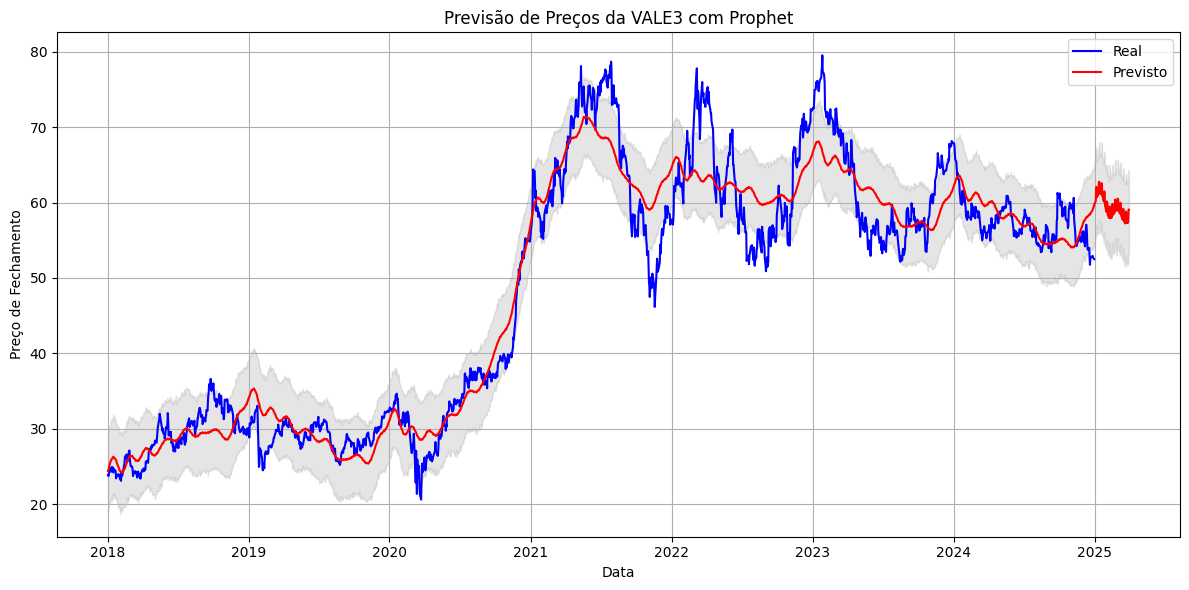

In [15]:
print('MAPE: ', mean_absolute_percentage_error(vale_df['y'], forecast['yhat'][:len(vale_df)]) * 100) 
print('MAE', mean_absolute_error(vale_df['y'], forecast['yhat'][:len(vale_df)]))
print('R2: ', r2_score(vale_df['y'], forecast['yhat'][:len(vale_df)]))
# Visualizando os dados reais e previstos:
plt.figure(figsize=(12,6))
plt.plot(vale_df['ds'], vale_df['y'], label='Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsto', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.title('Previsão de Preços da VALE3 com Prophet')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()